# Compute Driver Lifetime Value (DLV)

Now, that we have done some sufficient data exploration, we can estimate DLV. Now DLV for Lyft can be broken down into two types of value:

1. monetary (literal $ revenue generated)
2. platform (amount/quality of rides given to sustain usage of platform)

So, I'll take in the driver_df and rides_df to compute these two per driver.

In [1]:
# Necessary libs
import os
import numpy as np
import pandas as pd
import scipy
import sklearn
import datetime


# Plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import dabest

# custom libs
import sys
sys.path.append("../")
from src.data.rider import Fare, Ride

# Import magic commands for jupyter notebook 
# - autoreloading a module
# - profiling functions for memory usage and scripts
%load_ext autoreload
%autoreload 2

## 1. Load in Data - DataFrame

In [289]:
datadir = "../data/raw/"
interimdir = "../data/interim/"
rideid_fpath = os.path.join(datadir, "ride_ids.csv")
driveid_fpath = os.path.join(datadir, "driver_ids.csv")
ridetime_fpath = os.path.join(interimdir, "ride_timestamps_v2.csv")
                              
ride_df = pd.read_csv(rideid_fpath)
drive_df = pd.read_csv(driveid_fpath)
time_df = pd.read_csv(ridetime_fpath, index_col=None)

print(os.listdir(datadir))

['.gitkeep', 'ride_timestamps.csv', 'driver_ids.csv', 'ride_ids.csv']


In [290]:
display(ride_df.head())
display(drive_df.head())
display(time_df.head())

print("The size of the dataframes are: ", ride_df.shape, drive_df.shape, time_df.shape)

,driver_id,ride_id,ride_distance,ride_duration,ride_prime_time
0,002be0ffdc997bd5c50703158b7c2491,006d61cf7446e682f7bc50b0f8a5bea5,1811,327,50
1,002be0ffdc997bd5c50703158b7c2491,01b522c5c3a756fbdb12e95e87507eda,3362,809,0
2,002be0ffdc997bd5c50703158b7c2491,029227c4c2971ce69ff2274dc798ef43,3282,572,0
3,002be0ffdc997bd5c50703158b7c2491,034e861343a63ac3c18a9ceb1ce0ac69,65283,3338,25
4,002be0ffdc997bd5c50703158b7c2491,034f2e614a2f9fc7f1c2f77647d1b981,4115,823,100


,driver_id,driver_onboard_date
0,002be0ffdc997bd5c50703158b7c2491,2016-03-29 00:00:00
1,007f0389f9c7b03ef97098422f902e62,2016-03-29 00:00:00
2,011e5c5dfc5c2c92501b8b24d47509bc,2016-04-05 00:00:00
3,0152a2f305e71d26cc964f8d4411add9,2016-04-23 00:00:00
4,01674381af7edd264113d4e6ed55ecda,2016-04-29 00:00:00


,ride_id,event,timestamp,time_of_day,weekday,month,date,week_index
0,092ec855c70d70df6d4be5fb23e29081,accepted_at,2016-03-29 11:26:43,2,0.0,3,2016-03-29,1
1,a36318bb575fd2e0adefe8a9d5ecf5b3,accepted_at,2016-03-31 10:53:00,2,0.0,3,2016-03-31,1
2,a36318bb575fd2e0adefe8a9d5ecf5b3,arrived_at,2016-03-31 10:57:20,2,0.0,3,2016-03-31,1
3,a36318bb575fd2e0adefe8a9d5ecf5b3,picked_up_at,2016-03-31 10:57:23,2,0.0,3,2016-03-31,1
4,a36318bb575fd2e0adefe8a9d5ecf5b3,dropped_off_at,2016-03-31 11:23:02,2,0.0,3,2016-03-31,1


The size of the dataframes are:  (193502, 5) (937, 2) (970404, 8)


In [291]:
# convert meters to miles
def getMiles(i):
     return i*0.000621371192

def getMeters(i):
     return i*1609.344
    
ride_df['ride_distance_miles']=ride_df['ride_distance'].apply(getMiles)

In [292]:
# convert durations from seconds -> minutes, keep as float
def getMinutes(i):
    return i / 60.0

ride_df['ride_duration_mins']=ride_df['ride_duration'].apply(getMinutes)

In [293]:
ride_df['ride_prime_time'] = ride_df['ride_prime_time'] / 100

In [294]:
%%time
# takes a bit of time to run, ideally finish running everything and save
fare_cols = [
    'ride_distance_miles',
    'ride_duration_mins',
    'ride_prime_time',
]

def compute_fare(vec):
    vec = vec.tolist()
    ride = Ride(vec[0], vec[1], vec[2])
    return pd.Series([ride.fare, np.round(ride.mileage_percentage, 4), np.round(ride.time_percentage, 4), np.round(ride.lyftfee, 4)])

# pipeline of additions
ride_df[["fare_total", "mile_perc", "time_perc", "lyft_rev"]] = ride_df[fare_cols].apply(compute_fare, axis=1)

display(ride_df.head())

,driver_id,ride_id,ride_distance,ride_duration,ride_prime_time,ride_distance_miles,ride_duration_mins,fare_total,mile_perc,time_perc,lyft_rev
0,002be0ffdc997bd5c50703158b7c2491,006d61cf7446e682f7bc50b0f8a5bea5,1811,327,0.50,1.125303,5.450000,7.489648,0.5191,0.4809,0.4986
1,002be0ffdc997bd5c50703158b7c2491,01b522c5c3a756fbdb12e95e87507eda,3362,809,0.00,2.089050,13.483333,9.118741,0.4475,0.5525,1.0737
2,002be0ffdc997bd5c50703158b7c2491,029227c4c2971ce69ff2274dc798ef43,3282,572,0.00,2.039340,9.533333,8.192575,0.5279,0.4721,0.8885
3,002be0ffdc997bd5c50703158b7c2491,034e861343a63ac3c18a9ceb1ce0ac69,65283,3338,0.25,40.564976,55.633333,77.361319,0.7922,0.2078,11.7778
4,002be0ffdc997bd5c50703158b7c2491,034f2e614a2f9fc7f1c2f77647d1b981,4115,823,1.00,2.556942,13.716667,15.666301,0.4935,0.5065,1.1916


CPU times: user 1min 6s, sys: 3.3 s, total: 1min 10s
Wall time: 1min 11s


In [295]:
ride_df["pre_pt_fare"] = (ride_df["fare_total"] - 3.75).divide(1+ride_df["ride_prime_time"]).add(3.75).clip(lower=5) 
ride_df["pre_pt_lyft_rev"] = ride_df["pre_pt_fare"]*0.2

display(ride_df.head())

,driver_id,ride_id,ride_distance,ride_duration,ride_prime_time,ride_distance_miles,ride_duration_mins,fare_total,mile_perc,time_perc,lyft_rev,pre_pt_fare,pre_pt_lyft_rev
0,002be0ffdc997bd5c50703158b7c2491,006d61cf7446e682f7bc50b0f8a5bea5,1811,327,0.50,1.125303,5.450000,7.489648,0.5191,0.4809,0.4986,6.243099,1.248620
1,002be0ffdc997bd5c50703158b7c2491,01b522c5c3a756fbdb12e95e87507eda,3362,809,0.00,2.089050,13.483333,9.118741,0.4475,0.5525,1.0737,9.118741,1.823748
2,002be0ffdc997bd5c50703158b7c2491,029227c4c2971ce69ff2274dc798ef43,3282,572,0.00,2.039340,9.533333,8.192575,0.5279,0.4721,0.8885,8.192575,1.638515
3,002be0ffdc997bd5c50703158b7c2491,034e861343a63ac3c18a9ceb1ce0ac69,65283,3338,0.25,40.564976,55.633333,77.361319,0.7922,0.2078,11.7778,62.639055,12.527811
4,002be0ffdc997bd5c50703158b7c2491,034f2e614a2f9fc7f1c2f77647d1b981,4115,823,1.00,2.556942,13.716667,15.666301,0.4935,0.5065,1.1916,9.708150,1.941630


In [296]:
ride_df['is_prime_time'] = ride_df['ride_prime_time'].gt(0)

display(ride_df.head())

,driver_id,ride_id,ride_distance,ride_duration,ride_prime_time,ride_distance_miles,ride_duration_mins,fare_total,mile_perc,time_perc,lyft_rev,pre_pt_fare,pre_pt_lyft_rev,is_prime_time
0,002be0ffdc997bd5c50703158b7c2491,006d61cf7446e682f7bc50b0f8a5bea5,1811,327,0.50,1.125303,5.450000,7.489648,0.5191,0.4809,0.4986,6.243099,1.248620,True
1,002be0ffdc997bd5c50703158b7c2491,01b522c5c3a756fbdb12e95e87507eda,3362,809,0.00,2.089050,13.483333,9.118741,0.4475,0.5525,1.0737,9.118741,1.823748,False
2,002be0ffdc997bd5c50703158b7c2491,029227c4c2971ce69ff2274dc798ef43,3282,572,0.00,2.039340,9.533333,8.192575,0.5279,0.4721,0.8885,8.192575,1.638515,False
3,002be0ffdc997bd5c50703158b7c2491,034e861343a63ac3c18a9ceb1ce0ac69,65283,3338,0.25,40.564976,55.633333,77.361319,0.7922,0.2078,11.7778,62.639055,12.527811,True
4,002be0ffdc997bd5c50703158b7c2491,034f2e614a2f9fc7f1c2f77647d1b981,4115,823,1.00,2.556942,13.716667,15.666301,0.4935,0.5065,1.1916,9.708150,1.941630,True


is_prime_time       perc_pt_rides
                                           sum count              
driver_id                                                         
002be0ffdc997bd5c50703158b7c2491         110.0   277      0.397112
007f0389f9c7b03ef97098422f902e62          12.0    31      0.387097
011e5c5dfc5c2c92501b8b24d47509bc          16.0    34      0.470588
0152a2f305e71d26cc964f8d4411add9          48.0   191      0.251309
01674381af7edd264113d4e6ed55ecda          99.0   375      0.264000

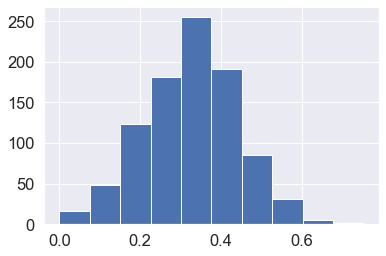

In [297]:
test = ride_df.groupby(['driver_id'])[['is_prime_time']].agg(['sum', 'count'])
test["perc_pt_rides"] = test["is_prime_time"]["sum"] / test["is_prime_time"]["count"]
display(test.head())

test["perc_pt_rides"].hist()

In [299]:
fpath = "../data/interim/ride_ids_v2.csv"

In [300]:
ride_df.to_csv(fpath, index=False)

## Load in ride DF If precomputed

In [303]:
ride_df = pd.read_csv(fpath, index_col=False)
display(ride_df.head())

,driver_id,ride_id,ride_distance,ride_duration,ride_prime_time,ride_distance_miles,ride_duration_mins,fare_total,mile_perc,time_perc,lyft_rev,pre_pt_fare,pre_pt_lyft_rev,is_prime_time
0,002be0ffdc997bd5c50703158b7c2491,006d61cf7446e682f7bc50b0f8a5bea5,1811,327,0.50,1.125303,5.450000,7.489648,0.5191,0.4809,0.4986,6.243099,1.248620,True
1,002be0ffdc997bd5c50703158b7c2491,01b522c5c3a756fbdb12e95e87507eda,3362,809,0.00,2.089050,13.483333,9.118741,0.4475,0.5525,1.0737,9.118741,1.823748,False
2,002be0ffdc997bd5c50703158b7c2491,029227c4c2971ce69ff2274dc798ef43,3282,572,0.00,2.039340,9.533333,8.192575,0.5279,0.4721,0.8885,8.192575,1.638515,False
3,002be0ffdc997bd5c50703158b7c2491,034e861343a63ac3c18a9ceb1ce0ac69,65283,3338,0.25,40.564976,55.633333,77.361319,0.7922,0.2078,11.7778,62.639055,12.527811,True
4,002be0ffdc997bd5c50703158b7c2491,034f2e614a2f9fc7f1c2f77647d1b981,4115,823,1.00,2.556942,13.716667,15.666301,0.4935,0.5065,1.1916,9.708150,1.941630,True


In [304]:
print(ride_df["fare_total"].mean())

13.227234943053737


# 1. Compute DLV (Revenue)

count rides, and group

In [305]:
driver_summ = ride_df.groupby(['driver_id']).agg(['mean', 'count', 'std'])

display(driver_summ.head())

ride_distance                      \
                                          mean count           std   
driver_id                                                            
002be0ffdc997bd5c50703158b7c2491   6282.624549   277   9429.618349   
007f0389f9c7b03ef97098422f902e62   3791.322581    31   2080.321776   
011e5c5dfc5c2c92501b8b24d47509bc   7930.970588    34  14857.037209   
0152a2f305e71d26cc964f8d4411add9   7702.821990   191   6661.567256   
01674381af7edd264113d4e6ed55ecda   8329.717333   375   9603.313564   

                                 ride_duration                    \
                                          mean count         std   
driver_id                                                          
002be0ffdc997bd5c50703158b7c2491    798.693141   277  501.906723   
007f0389f9c7b03ef97098422f902e62    661.193548    31  267.462698   
011e5c5dfc5c2c92501b8b24d47509bc    858.970588    34  743.742073   
0152a2f305e71d26cc964f8d4411add9    913.722513   191  547.786466   
01674381af7edd264113d4e6ed55ecda    953.181333   375  552.958426   

                                 ride_prime_time                  \
                                            mean count       std   
driver_id                                                          
002be0ffdc997bd5c50703158b7c2491        0.194043   277  0.311365   
007f0389f9c7b03ef97098422f902e62        0.201613    31  0.284454   
011e5c5dfc5c2c92501b8b24d47509bc        0.198529    34  0.259512   
0152a2f305e71d26cc964f8d4411add9        0.107330   191  0.213674   
01674381af7edd264113d4e6ed55ecda        0.125333   375  0.258463   

                                 ride_distance_miles  ...  lyft_rev  \
                                                mean  ...       std   
driver_id                                             ...             
002be0ffdc997bd5c50703158b7c2491            3.903842  ...  1.666610   
007f0389f9c7b03ef97098422f902e62            2.355819  ...  0.451215   
011e5c5dfc5c2c92501b8b24d47509bc            4.928077  ...  2.653441   
0152a2f305e71d26cc964f8d4411add9            4.786312  ...  1.289529   
01674381af7edd264113d4e6ed55ecda            5.175846  ...  1.717218   

                                 pre_pt_fare                  pre_pt_lyft_rev  \
                                        mean count        std            mean   
driver_id                                                                       
002be0ffdc997bd5c50703158b7c2491   11.197588   277   8.333046        2.239518   
007f0389f9c7b03ef97098422f902e62    8.922110    31   2.256060        1.784422   
011e5c5dfc5c2c92501b8b24d47509bc   12.593039    34  13.267160        2.518608   
0152a2f305e71d26cc964f8d4411add9   12.647754   191   6.447669        2.529551   
01674381af7edd264113d4e6ed55ecda   13.218699   375   8.586081        2.643740   

                                                 is_prime_time                  
                                 count       std          mean count       std  
driver_id                                                                       
002be0ffdc997bd5c50703158b7c2491   277  1.666609      0.397112   277  0.490185  
007f0389f9c7b03ef97098422f902e62    31  0.451212      0.387097    31  0.495138  
011e5c5dfc5c2c92501b8b24d47509bc    34  2.653432      0.470588    34  0.506640  
0152a2f305e71d26cc964f8d4411add9   191  1.289534      0.251309   191  0.434906  
01674381af7edd264113d4e6ed55ecda   375  1.717216      0.264000   375  0.441388  

[5 rows x 36 columns]

/Users/adam2392/miniconda3/envs/lyft/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  after removing the cwd from sys.path.


(937, 3)


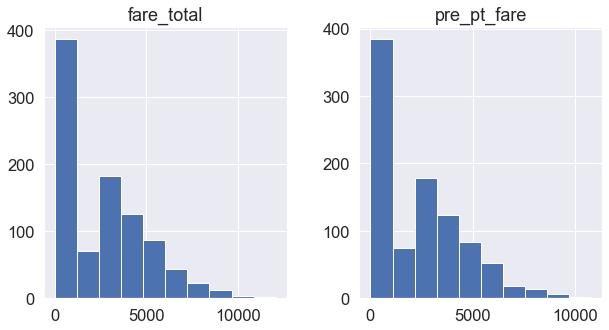

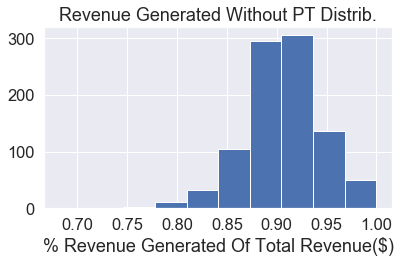

In [329]:
dlv_rev = ride_df.groupby(['driver_id'])[['fare_total', 'pre_pt_fare']].sum()

fig, ax = plt.subplots(1,1,figsize=(10,5))
hist = dlv_rev.hist(ax=ax)
ax.set_title("Revenue Generated In Dataset Distrib.")
ax.set_xlabel("Total Revenue Generated ($)")

dlv_rev["pt_perc_fare"] = dlv_rev["pre_pt_fare"]/dlv_rev["fare_total"]
print(dlv_rev.shape)

fig, ax = plt.subplots(1,1)
hist = dlv_rev["pt_perc_fare"].hist(ax=ax)
ax.set_title("Revenue Generated Without PT Distrib.")
ax.set_xlabel("% Revenue Generated Of Total Revenue($)")
fig.tight_layout()
plt.savefig("../reports/figures/pre_pt_rev_percentage.pdf")

0.0 546.3172712808505
KstestResult(statistic=0.9905953029906343, pvalue=0.0)
(546.3172712808505, 458.74889625053385)
KstestResult(statistic=0.9999758795101111, pvalue=0.0)


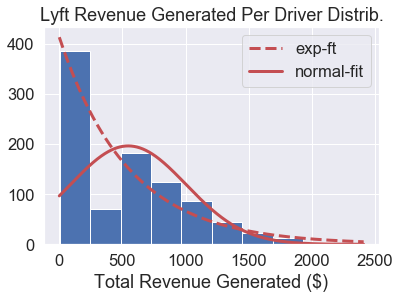

In [307]:
dlv_rev = ride_df.groupby(['driver_id'])[['fare_total']].sum()*0.2

nbins = 10

fig, ax = plt.subplots(1,1)
hist = dlv_rev.hist(ax=ax, bins=nbins)
ax.set_title("Lyft Revenue Generated Per Driver Distrib.")
ax.set_xlabel("Total Revenue Generated ($)")

revmax = dlv_rev.max().values
revx = np.linspace(0., revmax, len(dlv_rev))
factor = len(dlv_rev) * revmax / nbins

# fit exponential
dist = st.expon
args = dist.fit(dlv_rev, floc=0)
loc, scale = args
statres = st.kstest(dlv_rev, dist.cdf, args)
print(loc, scale)
print(statres)

dist = st.expon.pdf(revx, *args)
y = np.multiply(dist, factor)
ax.plot(revx, y,
        '--r', lw=3, label='exp-ft')

# Fit a normal distribution to the data:
dist = st.norm
args = dist.fit(dlv_rev)
mu, std = args
print(args)

statres = st.kstest(dlv_rev, dist.cdf, args)
print(statres)

dist = st.norm.pdf(revx, *args)
y = np.multiply(dist, factor)
ax.plot(revx, y, '-r', lw=3, label="normal-fit")
ax.legend()
# plt.savefig("../reports/figures/total_revenue_generated_perdriver.pdf")

In [308]:
print("Naive DLV based on 3 month period: ", dlv_rev.mean().values[0], "+/-", dlv_rev.sem().values[0])
print("Exponential fit average: ", scale, "+/-", loc)

Naive DLV based on 3 month period:  546.3172712808505 +/- 14.99467675526041
Exponential fit average:  546.3172712808505 +/- 0.0


#### Fit Exponential Distribution

(193502, 15)


Text(0.5, 0, '% Revenue Generated Of Total Revenue($)')

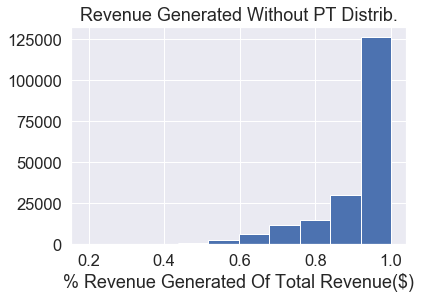

In [310]:
dlv_rev = ride_df.copy()
dlv_rev["pt_perc_fare"] = dlv_rev["pre_pt_fare"]/dlv_rev["fare_total"]
print(dlv_rev.shape)

fig, ax = plt.subplots(1,1)
hist = dlv_rev["pt_perc_fare"].hist(ax=ax)
ax.set_title("Revenue Generated Without PT Distrib.")
ax.set_xlabel("% Revenue Generated Of Total Revenue($)")

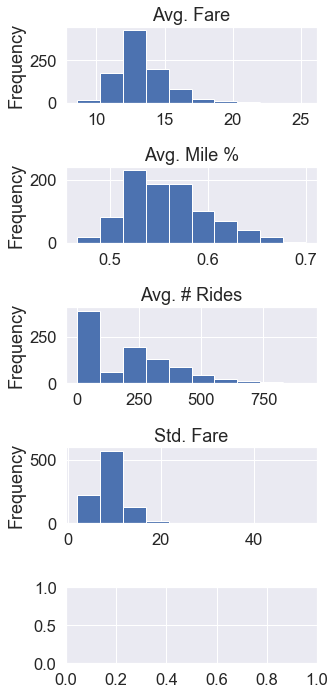

In [311]:
f, a = plt.subplots(5,1, figsize=(5,10))
driver_summ.xs(('fare_total', 'mean'), axis=1).plot(kind='hist', title="Avg. Fare", ax=a[0])
driver_summ.xs(('mile_perc','mean'), axis=1).plot(kind='hist',ax=a[1], title="Avg. Mile %")
driver_summ.xs(('fare_total', 'count'), axis=1).plot(kind='hist', title="Avg. # Rides", ax=a[2])
driver_summ.xs(('fare_total', 'std'), axis=1).plot(kind='hist', title="Std. Fare", ax=a[3])
# driver_summ.xs(('time_perc', 'mean'), axis=1).plot(kind='hist',ax=a[2], title="Avg. Time %")

f.tight_layout()

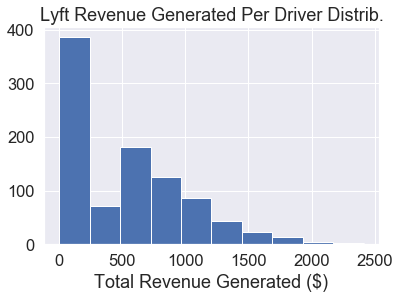

In [312]:
dlv_rev = ride_df.groupby(['driver_id'])[['fare_total']].sum()*0.2

fig, ax = plt.subplots(1,1)
hist = dlv_rev.hist(ax=ax)
ax.set_title("Lyft Revenue Generated Per Driver Distrib.")
ax.set_xlabel("Total Revenue Generated ($)")
plt.savefig("../reports/figures/total_revenue_generated_perdriver.pdf")

In [313]:
print(f"There are {194081 - 184819} rides without additional metadata.")

There are 9262 rides without additional metadata.


## DLV (Revenue) Over Time

In [314]:
# drop unnecessary data in time_df - events
indexNames = time_df[time_df['event'] != "requested_at"].index
print(time_df.shape)
# Delete these row indexes from dataFrame
time_df.drop(indexNames , inplace=True)
print(time_df.shape)

(970404, 8)
(194081, 8)


In [315]:
nride_df = pd.merge(ride_df, time_df, on="ride_id")

print(ride_df.shape, time_df.shape)
print(nride_df.shape)
display(nride_df.head())

(193502, 14) (194081, 8)
(184819, 21)


,driver_id,ride_id,ride_distance,ride_duration,ride_prime_time,ride_distance_miles,ride_duration_mins,fare_total,mile_perc,time_perc,...,pre_pt_fare,pre_pt_lyft_rev,is_prime_time,event,timestamp,time_of_day,weekday,month,date,week_index
0,002be0ffdc997bd5c50703158b7c2491,006d61cf7446e682f7bc50b0f8a5bea5,1811,327,0.50,1.125303,5.450000,7.489648,0.5191,0.4809,...,6.243099,1.248620,True,requested_at,2016-04-23 02:13:50,1,1.0,4,2016-04-23,4
1,002be0ffdc997bd5c50703158b7c2491,01b522c5c3a756fbdb12e95e87507eda,3362,809,0.00,2.089050,13.483333,9.118741,0.4475,0.5525,...,9.118741,1.823748,False,requested_at,2016-03-29 19:00:49,4,0.0,3,2016-03-29,1
2,002be0ffdc997bd5c50703158b7c2491,029227c4c2971ce69ff2274dc798ef43,3282,572,0.00,2.039340,9.533333,8.192575,0.5279,0.4721,...,8.192575,1.638515,False,requested_at,2016-06-21 11:56:31,2,0.0,6,2016-06-21,13
3,002be0ffdc997bd5c50703158b7c2491,034e861343a63ac3c18a9ceb1ce0ac69,65283,3338,0.25,40.564976,55.633333,77.361319,0.7922,0.2078,...,62.639055,12.527811,True,requested_at,2016-05-19 09:15:29,2,0.0,5,2016-05-19,8
4,002be0ffdc997bd5c50703158b7c2491,034f2e614a2f9fc7f1c2f77647d1b981,4115,823,1.00,2.556942,13.716667,15.666301,0.4935,0.5065,...,9.708150,1.941630,True,requested_at,2016-04-20 22:05:30,4,0.0,4,2016-04-20,4


#### Rides Over Days of Week and Times of Day

In [316]:
nride_df["timestamp"] = pd.to_datetime(nride_df["timestamp"])
nride_df['day_of_week'] = nride_df['timestamp'].dt.day_name()
display(nride_df.head())

,driver_id,ride_id,ride_distance,ride_duration,ride_prime_time,ride_distance_miles,ride_duration_mins,fare_total,mile_perc,time_perc,...,pre_pt_lyft_rev,is_prime_time,event,timestamp,time_of_day,weekday,month,date,week_index,day_of_week
0,002be0ffdc997bd5c50703158b7c2491,006d61cf7446e682f7bc50b0f8a5bea5,1811,327,0.50,1.125303,5.450000,7.489648,0.5191,0.4809,...,1.248620,True,requested_at,2016-04-23 02:13:50,1,1.0,4,2016-04-23,4,Saturday
1,002be0ffdc997bd5c50703158b7c2491,01b522c5c3a756fbdb12e95e87507eda,3362,809,0.00,2.089050,13.483333,9.118741,0.4475,0.5525,...,1.823748,False,requested_at,2016-03-29 19:00:49,4,0.0,3,2016-03-29,1,Tuesday
2,002be0ffdc997bd5c50703158b7c2491,029227c4c2971ce69ff2274dc798ef43,3282,572,0.00,2.039340,9.533333,8.192575,0.5279,0.4721,...,1.638515,False,requested_at,2016-06-21 11:56:31,2,0.0,6,2016-06-21,13,Tuesday
3,002be0ffdc997bd5c50703158b7c2491,034e861343a63ac3c18a9ceb1ce0ac69,65283,3338,0.25,40.564976,55.633333,77.361319,0.7922,0.2078,...,12.527811,True,requested_at,2016-05-19 09:15:29,2,0.0,5,2016-05-19,8,Thursday
4,002be0ffdc997bd5c50703158b7c2491,034f2e614a2f9fc7f1c2f77647d1b981,4115,823,1.00,2.556942,13.716667,15.666301,0.4935,0.5065,...,1.941630,True,requested_at,2016-04-20 22:05:30,4,0.0,4,2016-04-20,4,Wednesday


count
day_of_week time_of_day       
Friday      1             2074
            2            15566
            3            25332
            4            56336
Monday      1             1219

,,count
day_of_week,time_of_day,
Tuesday,1,1120
Monday,1,1219
Wednesday,1,1282
Thursday,1,1458
Friday,1,2074


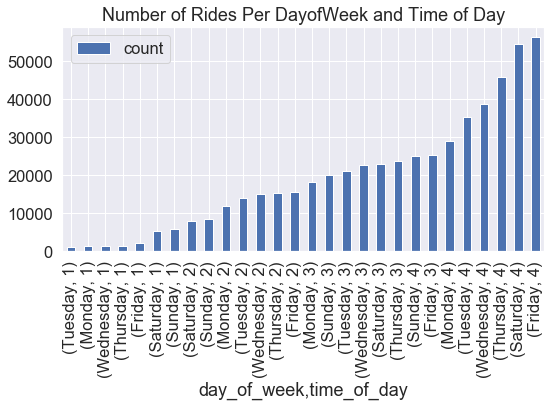

In [218]:
"""
Time of Day split by time of week
"""
df = nride_df.copy()
test = df.groupby(['day_of_week', 'time_of_day'])#.value_counts().unstack().stack(dropna=False).reset_index(name="Count")
test = test[["day_of_week", 'time_of_day']].sum().rename(columns={'time_of_day':'count'})

display(test.head())
test = test.groupby(["day_of_week", 'time_of_day']).sum()
test.sort_values(by="count", inplace=True)

display(test.head())

fig, ax = plt.subplots(1,1, figsize=(8,6))
test.plot(kind="bar", ax=ax)
ax.set_title("Number of Rides Per DayofWeek and Time of Day")
fig.tight_layout()

plt.savefig("../reports/figures/number_ride_dayofweek_timeofday.pdf")

,Count
day_of_week,
Monday,20497.0
Sunday,22869.0
Tuesday,23937.0
Wednesday,26092.0
Thursday,28417.0


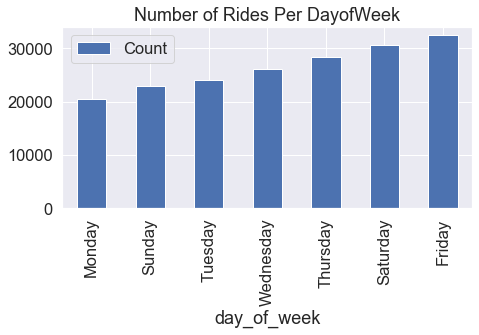

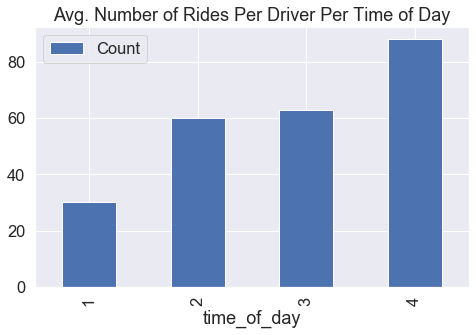

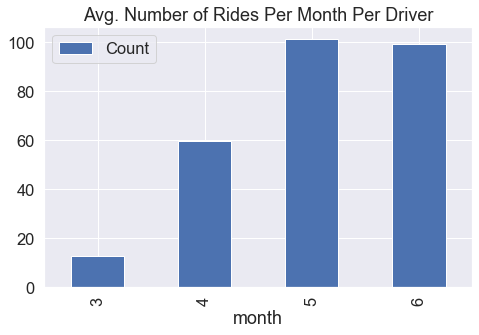

In [246]:
"""
Time of Day/Week
"""
df = nride_df.copy()
test = df.groupby('driver_id')['day_of_week'].value_counts().unstack().stack(dropna=False).reset_index(name="Count")
test = test.groupby("day_of_week").sum()
test.sort_values(by="Count", inplace=True)

display(test.head())

fig, ax = plt.subplots(1,1,figsize=(7,5))
test.plot(kind="bar", ax=ax)
ax.set_title("Number of Rides Per DayofWeek")
fig.tight_layout()
plt.savefig("../reports/figures/avg_number_rides_per_dayofweekdriver.pdf")

df = nride_df.copy()
test = df.groupby('driver_id')['time_of_day'].value_counts().unstack().stack(dropna=False).reset_index(name="Count")
test = test.groupby("time_of_day").agg("mean")

fig, ax = plt.subplots(1,1,figsize=(7,5))
test.plot(kind="bar", ax=ax)
ax.set_title("Avg. Number of Rides Per Driver Per Time of Day")
fig.tight_layout()
plt.savefig("../reports/figures/avg_number_rides_per_timeofdaydriver.pdf")

df = nride_df.copy()
test = df.groupby('driver_id')['month'].value_counts().unstack().stack(dropna=False).reset_index(name="Count")
test = test.groupby("month").agg("mean")

fig, ax = plt.subplots(1,1,figsize=(7,5))
test.plot(kind="bar", ax=ax)
ax.set_title("Avg. Number of Rides Per Month Per Driver")
fig.tight_layout()
plt.savefig("../reports/figures/avg_number_rides_per_monthdriver.pdf")

#### Rides Per Driver Per Month

Text(0.5, 1.0, 'Number of Rides Per Month')

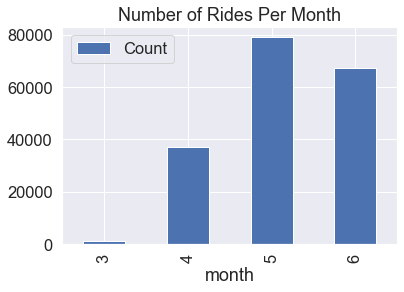

In [221]:
df = nride_df.copy()
test = df.groupby('driver_id')['month'].value_counts().unstack().stack(dropna=False).reset_index(name="Count")
test = test.groupby("month").sum()

fig, ax = plt.subplots(1,1)
test.plot(kind="bar", ax=ax)
ax.set_title("Number of Rides Per Month")

count
month day_of_week time_of_day       
3     Monday      1                1
      Tuesday     1                4
      Wednesday   1                4
      Thursday    1               29
      Monday      2               52

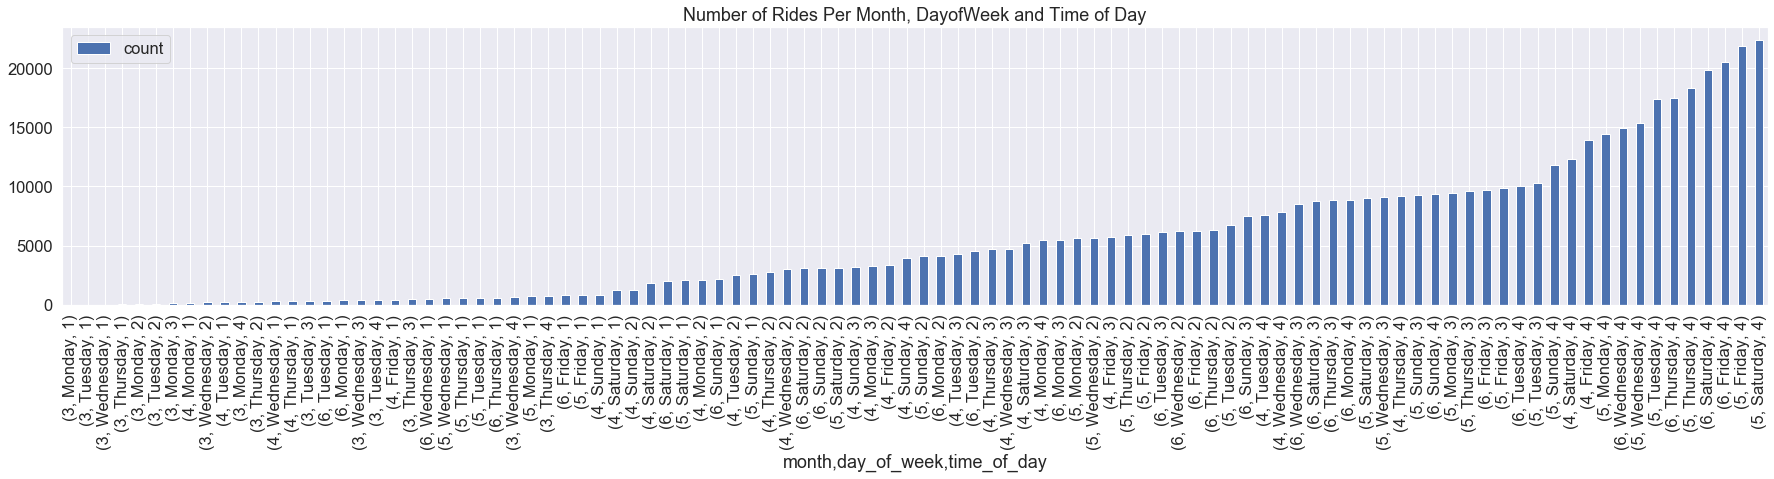

In [242]:
"""
Time of Day split by time of week time of day time of month
"""
df = nride_df.copy()
test = df.groupby([ "month", 'day_of_week','time_of_day'])#.value_counts().unstack().stack(dropna=False).reset_index(name="Count")
test = test[[ "day_of_week", 'time_of_day']].sum().rename(columns={'time_of_day':'count'})

# display(test.head())
# test = test.groupby(["day_of_week", 'time_of_day']).sum()
test.sort_values(by="count", inplace=True)

display(test.head())

fig, ax = plt.subplots(1,1, figsize=(25,7))
test.plot(kind="bar", ax=ax)
ax.set_title("Number of Rides Per Month, DayofWeek and Time of Day")
fig.tight_layout()
plt.savefig("../reports/figures/number_ride_month_dayofweek_timeofday.pdf")

# PT per Month

,driver_id,ride_id,ride_distance,ride_duration,ride_prime_time,is_prime_time,event,timestamp,time_of_day,weekday,month,day_of_week
0,002be0ffdc997bd5c50703158b7c2491,006d61cf7446e682f7bc50b0f8a5bea5,1811,327,50,True,requested_at,2016-04-23 02:13:50,1,1.0,4,Saturday
1,002be0ffdc997bd5c50703158b7c2491,01b522c5c3a756fbdb12e95e87507eda,3362,809,0,False,requested_at,2016-03-29 19:00:49,4,0.0,3,Tuesday
2,002be0ffdc997bd5c50703158b7c2491,029227c4c2971ce69ff2274dc798ef43,3282,572,0,False,requested_at,2016-06-21 11:56:31,2,0.0,6,Tuesday
3,002be0ffdc997bd5c50703158b7c2491,034e861343a63ac3c18a9ceb1ce0ac69,65283,3338,25,True,requested_at,2016-05-19 09:15:29,2,0.0,5,Thursday
4,002be0ffdc997bd5c50703158b7c2491,034f2e614a2f9fc7f1c2f77647d1b981,4115,823,100,True,requested_at,2016-04-20 22:05:30,4,0.0,4,Wednesday


(184819, 12)


,sum,mean,sem
month,,,
3,160.0,0.130719,0.009639
4,9803.0,0.263876,0.002287
6,25163.0,0.373832,0.001865
5,30216.0,0.381833,0.001727


,driver_id,ride_id,ride_distance,ride_duration,ride_prime_time,is_prime_time,event,timestamp,time_of_day,weekday,month,day_of_week
0,002be0ffdc997bd5c50703158b7c2491,006d61cf7446e682f7bc50b0f8a5bea5,1811,327,50,True,requested_at,2016-04-23 02:13:50,1,1.0,4,Saturday
1,002be0ffdc997bd5c50703158b7c2491,01b522c5c3a756fbdb12e95e87507eda,3362,809,0,False,requested_at,2016-03-29 19:00:49,4,0.0,3,Tuesday
2,002be0ffdc997bd5c50703158b7c2491,029227c4c2971ce69ff2274dc798ef43,3282,572,0,False,requested_at,2016-06-21 11:56:31,2,0.0,6,Tuesday
3,002be0ffdc997bd5c50703158b7c2491,034e861343a63ac3c18a9ceb1ce0ac69,65283,3338,25,True,requested_at,2016-05-19 09:15:29,2,0.0,5,Thursday
4,002be0ffdc997bd5c50703158b7c2491,034f2e614a2f9fc7f1c2f77647d1b981,4115,823,100,True,requested_at,2016-04-20 22:05:30,4,0.0,4,Wednesday


(184819, 12)


,sum,mean,sem
day_of_week,,,
Tuesday,7154.0,0.298868,0.002959
Wednesday,8278.0,0.317262,0.002881
Monday,7064.0,0.344636,0.003320
Thursday,9804.0,0.345005,0.002820
Saturday,10905.0,0.356117,0.002736


,driver_id,ride_id,ride_distance,ride_duration,ride_prime_time,is_prime_time,event,timestamp,time_of_day,weekday,month,day_of_week
0,002be0ffdc997bd5c50703158b7c2491,006d61cf7446e682f7bc50b0f8a5bea5,1811,327,50,True,requested_at,2016-04-23 02:13:50,1,1.0,4,Saturday
1,002be0ffdc997bd5c50703158b7c2491,01b522c5c3a756fbdb12e95e87507eda,3362,809,0,False,requested_at,2016-03-29 19:00:49,4,0.0,3,Tuesday
2,002be0ffdc997bd5c50703158b7c2491,029227c4c2971ce69ff2274dc798ef43,3282,572,0,False,requested_at,2016-06-21 11:56:31,2,0.0,6,Tuesday
3,002be0ffdc997bd5c50703158b7c2491,034e861343a63ac3c18a9ceb1ce0ac69,65283,3338,25,True,requested_at,2016-05-19 09:15:29,2,0.0,5,Thursday
4,002be0ffdc997bd5c50703158b7c2491,034f2e614a2f9fc7f1c2f77647d1b981,4115,823,100,True,requested_at,2016-04-20 22:05:30,4,0.0,4,Wednesday


(184819, 12)


,sum,mean,sem
time_of_day,,,
2,14109.0,0.320251,0.002223
1,5983.0,0.329642,0.003489
3,18649.0,0.363217,0.002122
4,26601.0,0.373248,0.001812


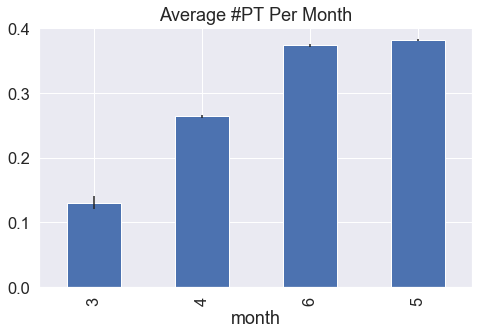

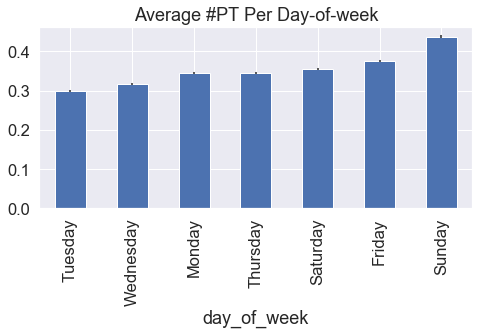

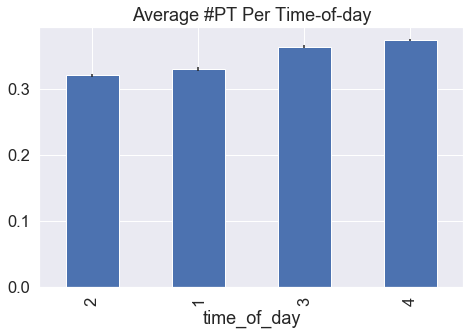

In [248]:
df = nride_df.copy()
display(df.head())
print(df.shape)
test = df.groupby("month")['is_prime_time'].agg(["sum", "mean", "sem"])#.value_counts().unstack().stack(dropna=False).reset_index(name="Count")
test.sort_values(by="mean", inplace=True)
display(test.head())
std = test["sem"]

fig, ax = plt.subplots(1,1, figsize=(7,5))
test["mean"].plot(kind="bar", ax=ax, yerr=std)
ax.set_title("Average #PT Per Month")
fig.tight_layout()
plt.savefig("../reports/figures/avg_number_pt_per_month.pdf")

df = nride_df.copy()
display(df.head())
print(df.shape)
test = df.groupby("day_of_week")['is_prime_time'].agg(["sum", "mean", "sem"])#.value_counts().unstack().stack(dropna=False).reset_index(name="Count")
test.sort_values(by="mean", inplace=True)
display(test.head())
std = test["sem"]

fig, ax = plt.subplots(1,1, figsize=(7,5))
test["mean"].plot(kind="bar", ax=ax, yerr=std)
ax.set_title("Average #PT Per Day-of-week")
fig.tight_layout()
plt.savefig("../reports/figures/avg_number_pt_per_dayofweek.pdf")

df = nride_df.copy()
display(df.head())
print(df.shape)
test = df.groupby("time_of_day")['is_prime_time'].agg(["sum", "mean", "sem"])#.value_counts().unstack().stack(dropna=False).reset_index(name="Count")
test.sort_values(by="mean", inplace=True)
display(test.head())
std = test["sem"]

fig, ax = plt.subplots(1,1, figsize=(7,5))
test["mean"].plot(kind="bar", ax=ax, yerr=std)
ax.set_title("Average #PT Per Time-of-day")
fig.tight_layout()
plt.savefig("../reports/figures/avg_number_pt_per_timeofday.pdf")

is_prime_time
month day_of_week time_of_day               
3     Wednesday   1                      0.0
      Thursday    1                      0.0
      Tuesday     1                      1.0
      Monday      1                      1.0
                  3                      2.0

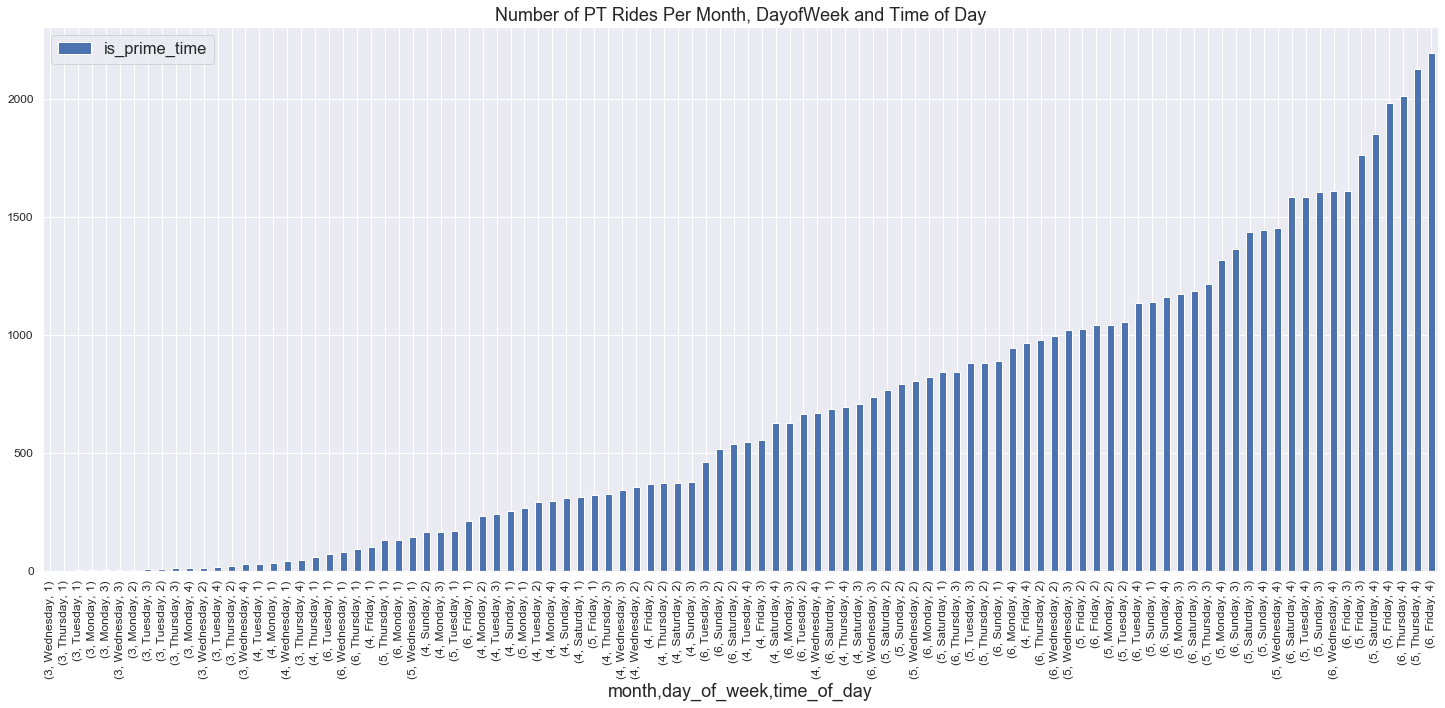

In [235]:
"""
PT Per month, day of week, time of day
"""

df = nride_df.copy()
test = df.groupby([ "month", 'day_of_week','time_of_day'])#.value_counts().unstack().stack(dropna=False).reset_index(name="Count")
test = test[["is_prime_time"]].sum()#.rename(columns={'time_of_day':'count'})

# display(test.head())
# test = test.groupby(["day_of_week", 'time_of_day']).sum()
test.sort_values(by="is_prime_time", inplace=True)

display(test.head())

fig, ax = plt.subplots(1,1, figsize=(25,10))
test.plot(kind="bar", ax=ax, fontsize=12)
ax.set_title("Number of PT Rides Per Month, DayofWeek and Time of Day")

plt.savefig("../reports/figures/number_pt_month_dayofweek_timeofday.pdf")

##### Revenue Per Month 

In [317]:
display(nride_df.head())

,driver_id,ride_id,ride_distance,ride_duration,ride_prime_time,ride_distance_miles,ride_duration_mins,fare_total,mile_perc,time_perc,...,pre_pt_lyft_rev,is_prime_time,event,timestamp,time_of_day,weekday,month,date,week_index,day_of_week
0,002be0ffdc997bd5c50703158b7c2491,006d61cf7446e682f7bc50b0f8a5bea5,1811,327,0.50,1.125303,5.450000,7.489648,0.5191,0.4809,...,1.248620,True,requested_at,2016-04-23 02:13:50,1,1.0,4,2016-04-23,4,Saturday
1,002be0ffdc997bd5c50703158b7c2491,01b522c5c3a756fbdb12e95e87507eda,3362,809,0.00,2.089050,13.483333,9.118741,0.4475,0.5525,...,1.823748,False,requested_at,2016-03-29 19:00:49,4,0.0,3,2016-03-29,1,Tuesday
2,002be0ffdc997bd5c50703158b7c2491,029227c4c2971ce69ff2274dc798ef43,3282,572,0.00,2.039340,9.533333,8.192575,0.5279,0.4721,...,1.638515,False,requested_at,2016-06-21 11:56:31,2,0.0,6,2016-06-21,13,Tuesday
3,002be0ffdc997bd5c50703158b7c2491,034e861343a63ac3c18a9ceb1ce0ac69,65283,3338,0.25,40.564976,55.633333,77.361319,0.7922,0.2078,...,12.527811,True,requested_at,2016-05-19 09:15:29,2,0.0,5,2016-05-19,8,Thursday
4,002be0ffdc997bd5c50703158b7c2491,034f2e614a2f9fc7f1c2f77647d1b981,4115,823,1.00,2.556942,13.716667,15.666301,0.4935,0.5065,...,1.941630,True,requested_at,2016-04-20 22:05:30,4,0.0,4,2016-04-20,4,Wednesday


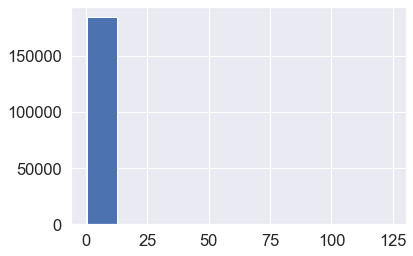

In [318]:
fig, ax = plt.subplots(1,1)
nride_df["lyft_rev"].hist(ax=ax)

,driver_id,ride_id,ride_distance,ride_duration,ride_prime_time,ride_distance_miles,ride_duration_mins,fare_total,mile_perc,time_perc,lyft_rev,pre_pt_fare,pre_pt_lyft_rev,is_prime_time,event,timestamp,time_of_day,weekday,month
0,002be0ffdc997bd5c50703158b7c2491,006d61cf7446e682f7bc50b0f8a5bea5,1811,327,0.50,1.125303,5.450000,7.489648,0.5191,0.4809,0.4986,6.243099,1.248620,True,requested_at,2016-04-23 02:13:50,1,1.0,4
1,002be0ffdc997bd5c50703158b7c2491,01b522c5c3a756fbdb12e95e87507eda,3362,809,0.00,2.089050,13.483333,9.118741,0.4475,0.5525,1.0737,9.118741,1.823748,False,requested_at,2016-03-29 19:00:49,4,0.0,3
2,002be0ffdc997bd5c50703158b7c2491,029227c4c2971ce69ff2274dc798ef43,3282,572,0.00,2.039340,9.533333,8.192575,0.5279,0.4721,0.8885,8.192575,1.638515,False,requested_at,2016-06-21 11:56:31,2,0.0,6
3,002be0ffdc997bd5c50703158b7c2491,034e861343a63ac3c18a9ceb1ce0ac69,65283,3338,0.25,40.564976,55.633333,77.361319,0.7922,0.2078,11.7778,62.639055,12.527811,True,requested_at,2016-05-19 09:15:29,2,0.0,5
4,002be0ffdc997bd5c50703158b7c2491,034f2e614a2f9fc7f1c2f77647d1b981,4115,823,1.00,2.556942,13.716667,15.666301,0.4935,0.5065,1.1916,9.708150,1.941630,True,requested_at,2016-04-20 22:05:30,4,0.0,4


(184819, 19)


,sum,mean,std
month,,,
3,1893.3873,1.546885,1.570739
4,58206.3892,1.566794,1.479252
5,130978.0931,1.655143,1.632322
6,110079.3087,1.635384,1.688927


Text(0.5, 1.0, 'Average Revenue Per Month')

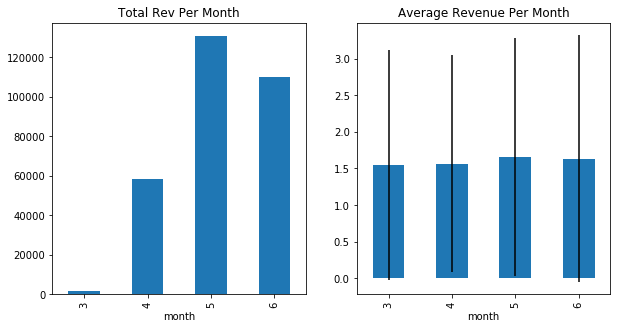

In [256]:
# df = nride_df.copy()
# test = df.groupby('driver_id')['month'].value_counts().unstack().stack(dropna=False).reset_index(name="Count")
# test = test.groupby("month").sum()

# fig, ax = plt.subplots(1,1)
# test.plot(kind="bar", ax=ax)
# ax.set_title("Number of Rides Per Month")

df = nride_df.copy()
display(df.head())
print(df.shape)
test = df.groupby("month")['lyft_rev'].agg(["sum", "mean", "std"])#.value_counts().unstack().stack(dropna=False).reset_index(name="Count")
display(test.head())
std = test["std"]
# test = test.groupby("month").agg("mean")

fig, ax = plt.subplots(1,2, figsize=(10,5))
test["sum"].plot(kind="bar", ax=ax[0])
ax[0].set_title("Total Rev Per Month")

test["mean"].plot(kind="bar", ax=ax[1], yerr=std)
ax[1].set_title("Average Revenue Per Month")
# plt.savefig("../reports/figures/avg_number_rides_per_monthdriver.pdf")

# 2. Compute DLV (Rides)

In [319]:
# driver vs # rides
display(nride_df.head())
print(nride_df.shape)

,driver_id,ride_id,ride_distance,ride_duration,ride_prime_time,ride_distance_miles,ride_duration_mins,fare_total,mile_perc,time_perc,...,pre_pt_lyft_rev,is_prime_time,event,timestamp,time_of_day,weekday,month,date,week_index,day_of_week
0,002be0ffdc997bd5c50703158b7c2491,006d61cf7446e682f7bc50b0f8a5bea5,1811,327,0.50,1.125303,5.450000,7.489648,0.5191,0.4809,...,1.248620,True,requested_at,2016-04-23 02:13:50,1,1.0,4,2016-04-23,4,Saturday
1,002be0ffdc997bd5c50703158b7c2491,01b522c5c3a756fbdb12e95e87507eda,3362,809,0.00,2.089050,13.483333,9.118741,0.4475,0.5525,...,1.823748,False,requested_at,2016-03-29 19:00:49,4,0.0,3,2016-03-29,1,Tuesday
2,002be0ffdc997bd5c50703158b7c2491,029227c4c2971ce69ff2274dc798ef43,3282,572,0.00,2.039340,9.533333,8.192575,0.5279,0.4721,...,1.638515,False,requested_at,2016-06-21 11:56:31,2,0.0,6,2016-06-21,13,Tuesday
3,002be0ffdc997bd5c50703158b7c2491,034e861343a63ac3c18a9ceb1ce0ac69,65283,3338,0.25,40.564976,55.633333,77.361319,0.7922,0.2078,...,12.527811,True,requested_at,2016-05-19 09:15:29,2,0.0,5,2016-05-19,8,Thursday
4,002be0ffdc997bd5c50703158b7c2491,034f2e614a2f9fc7f1c2f77647d1b981,4115,823,1.00,2.556942,13.716667,15.666301,0.4935,0.5065,...,1.941630,True,requested_at,2016-04-20 22:05:30,4,0.0,4,2016-04-20,4,Wednesday


(184819, 22)


,index,driver_id,lyft_rev
0,0,002be0ffdc997bd5c50703158b7c2491,412.5966
1,1,007f0389f9c7b03ef97098422f902e62,32.0671
2,2,011e5c5dfc5c2c92501b8b24d47509bc,60.1324
3,3,0152a2f305e71d26cc964f8d4411add9,339.8944
4,4,01674381af7edd264113d4e6ed55ecda,710.1527


(844, 3)


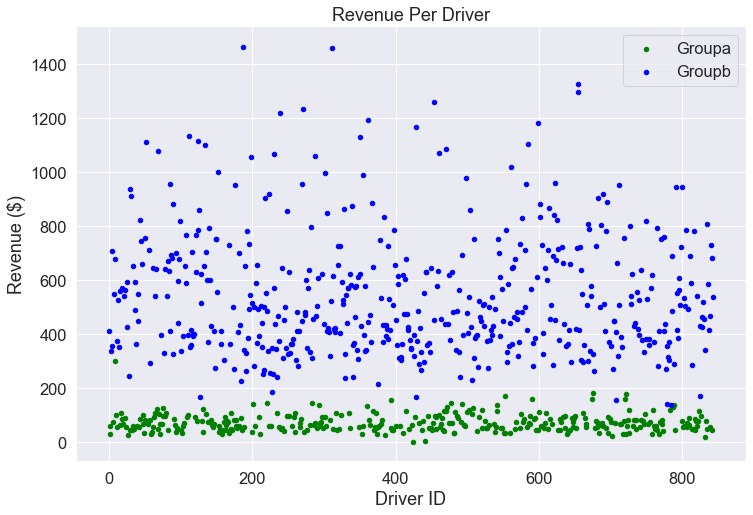

In [352]:
df = nride_df.copy()
test = df.groupby("driver_id")[['lyft_rev']].sum()
test.reset_index(inplace=True)
test.reset_index(inplace=True)
display(test.head())
print(test.shape)

# groupainds = test["lyft_rev"] < 169.3115400000001
# groupbinds = test["lyft_rev"] >= 169.3115400000001
# groupa = test[test["lyft_rev"] < 169.3115400000001]
# groupb = test[test["lyft_rev"] >= 169.3115400000001]
'''
Rides Per Driver
'''
sns.set(font_scale=1.5)
fig, ax = plt.subplots(1,1, figsize=(12,8))
# test.plot(kind="scatter", x="index", y="lyft_rev", ax=ax)
# groupa.plot(kind="scatter", x="index", y="lyft_rev", ax=ax, color="green", label="GroupA")
# groupb.plot(kind="scatter", x="index", y="lyft_rev", ax=ax, color="blue", label="GroupB")

test[groupainds].plot(kind="scatter", x="index", y="lyft_rev", ax=ax, color="green", label="Groupa")
test[groupbinds].plot(kind="scatter", x="index", y="lyft_rev", ax=ax, color="blue", label="Groupb")


# quantiles = [0.25, 0.4, 0.5, 0.9]
# colors = ["black", "green", "red", "blue"]
# for q, col in zip(quantiles, colors):
#     computed_q = test["lyft_rev"].quantile(q=q)
#     print(f"Computed quantile for {q} was {computed_q}.")
#     ax.axhline(computed_q, linestyle="--", linewidth=3,
#                color=col, 
#                label=f"Quantile {q}")
ax.set_xlabel("Driver ID")
ax.set_ylabel("Revenue ($)")
ax.set_title("Revenue Per Driver")
ax.legend()
plt.savefig("../reports/figures/revenue_per_driver.pdf")

,index,driver_id,event
0,0,002be0ffdc997bd5c50703158b7c2491,277
1,1,007f0389f9c7b03ef97098422f902e62,31
2,2,011e5c5dfc5c2c92501b8b24d47509bc,34
3,3,0152a2f305e71d26cc964f8d4411add9,191
4,4,01674381af7edd264113d4e6ed55ecda,375


(844, 3)
Computed quantile for 0.4 was 83.0.
Computed quantile for 0.5 was 224.0.


Text(0.5, 1.0, 'Total Rev Per Month')

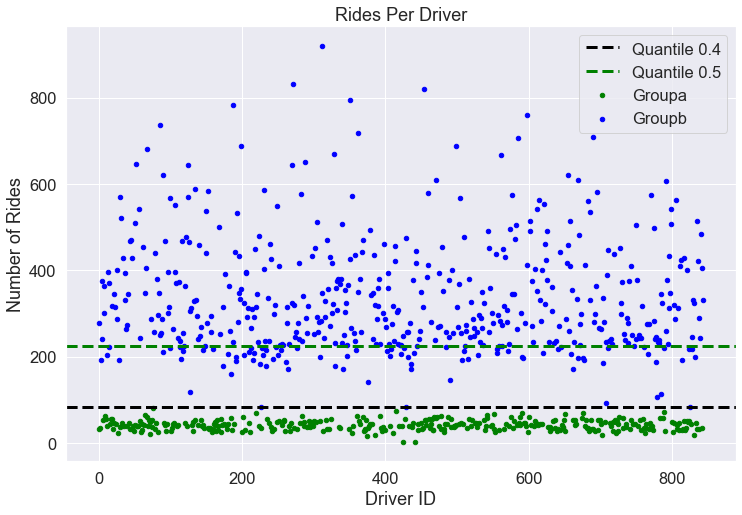

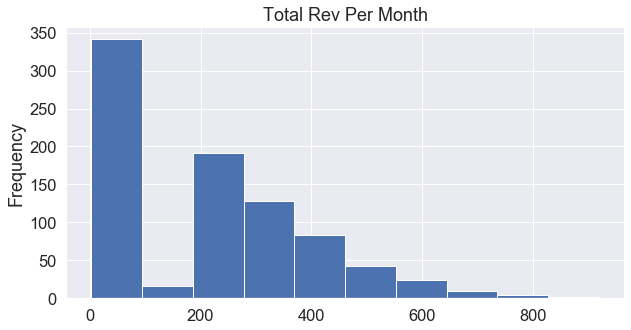

In [351]:
df = nride_df.copy()
test = df.groupby("driver_id")[['event']].count()
test.reset_index(inplace=True)
test.reset_index(inplace=True)
display(test.head())
print(test.shape)

# groupainds = test["event"] < 83
# groupbinds = test["event"] >= 83
# groupa = test[groupainds]
# groupb = test[groupbinds]

'''
Rides Per Driver
'''
sns.set(font_scale=1.5)
fig, ax = plt.subplots(1,1, figsize=(12,8))
# test.plot(kind="scatter", x="index", y="event", ax=ax)

test[groupainds].plot(kind="scatter", x="index", y="event", ax=ax, color="green", label="Groupa")
test[groupbinds].plot(kind="scatter", x="index", y="event", ax=ax, color="blue", label="Groupb")

quantiles = [0.4, 0.5]
colors = ["black", "green", "red", "blue"]
for q, col in zip(quantiles, colors):
    computed_q = test["event"].quantile(q=q)
    print(f"Computed quantile for {q} was {computed_q}.")
    ax.axhline(computed_q, linestyle="--", linewidth=3,
               color=col, 
               label=f"Quantile {q}")
ax.set_xlabel("Driver ID")
ax.set_ylabel("Number of Rides")
ax.set_title("Rides Per Driver")
ax.legend()
plt.savefig("../reports/figures/number_rides_per_driver.pdf")

'''
Histogram to check
'''
fig, ax = plt.subplots(1,1, figsize=(10,5))
test["event"].plot(kind="hist", ax=ax)
ax.set_title("Total Rev Per Month")

# test["mean"].plot(kind="bar", ax=ax[1], yerr=std)
# ax[1].set_title("Average Revenue Per Month")
# plt.savefig("../reports/figures/avg_number_rides_per_monthdriver.pdf")

In [339]:
"""
Split by # rides
"""
df = nride_df.copy()
test = df.groupby("driver_id")[['event']].count()
test.reset_index(inplace=True)
test.reset_index(inplace=True)
print(test.shape)

qval = test["event"].quantile(q=0.4)
test["pop1"] = test["event"] <= qval

display(test.head())

# df = nride_df.copy()
# test = df.groupby("driver_id")[['lyft_rev']].sum()
# test.reset_index(inplace=True)
# test.reset_index(inplace=True)
# print(test.shape)

# qval = test["lyft_rev"].quantile(q=0.4)
# test["pop1"] = test["lyft_rev"] <= qval

# display(test.head())

(844, 3)


,index,driver_id,event,pop1
0,0,002be0ffdc997bd5c50703158b7c2491,277,False
1,1,007f0389f9c7b03ef97098422f902e62,31,True
2,2,011e5c5dfc5c2c92501b8b24d47509bc,34,True
3,3,0152a2f305e71d26cc964f8d4411add9,191,False
4,4,01674381af7edd264113d4e6ed55ecda,375,False


In [340]:
pop1_df = test[test["pop1"]]
pop2_df = test[~test["pop1"]]
print(pop1_df.shape, pop2_df.shape, test.shape)

(340, 4) (504, 4) (844, 4)


In [341]:
# merge in ddataframes
pop1_df = pop1_df.merge(nride_df, how="left", on="driver_id")

print(len(pop1_df["driver_id"].unique()))
print(pop1_df.shape)
display(pop1_df.head())

340
(14218, 25)


,index,driver_id,event_x,pop1,ride_id,ride_distance,ride_duration,ride_prime_time,ride_distance_miles,ride_duration_mins,...,pre_pt_lyft_rev,is_prime_time,event_y,timestamp,time_of_day,weekday,month,date,week_index,day_of_week
0,1,007f0389f9c7b03ef97098422f902e62,31,True,01f133164433ea7682545a41643e6949,4711,856,0.25,2.927280,14.266667,...,2.051008,True,requested_at,2016-05-18 21:12:45,4,0.0,5,2016-05-18,8,Wednesday
1,1,007f0389f9c7b03ef97098422f902e62,31,True,07f9b5246c8431e3e5bac56d9f48b4f9,3047,611,0.00,1.893318,10.183333,...,1.633530,False,requested_at,2016-04-08 20:29:08,4,0.0,4,2016-04-08,2,Friday
2,1,007f0389f9c7b03ef97098422f902e62,31,True,13ac4cc1bf311c6944d0e6cd4c93ebb1,1091,200,0.50,0.677916,3.333333,...,1.126667,True,requested_at,2016-05-18 21:40:17,4,0.0,5,2016-05-18,8,Wednesday
3,1,007f0389f9c7b03ef97098422f902e62,31,True,274033cb9ee08c4499d4f16ce9db9a82,4383,581,0.00,2.723470,9.683333,...,1.802465,False,requested_at,2016-04-27 21:35:10,4,0.0,4,2016-04-27,5,Wednesday
4,1,007f0389f9c7b03ef97098422f902e62,31,True,2ca7357aa39d812da3055ae3d8ffa3e5,4209,640,0.00,2.615351,10.666667,...,1.820864,False,requested_at,2016-06-14 20:56:49,4,0.0,6,2016-06-14,12,Tuesday


In [342]:
# merge in ddataframes
pop2_df = pop2_df.merge(nride_df, how="left", on="driver_id")

print(len(pop2_df["driver_id"].unique()))
print(pop2_df.shape)
display(pop2_df.head())

504
(170601, 25)


,index,driver_id,event_x,pop1,ride_id,ride_distance,ride_duration,ride_prime_time,ride_distance_miles,ride_duration_mins,...,pre_pt_lyft_rev,is_prime_time,event_y,timestamp,time_of_day,weekday,month,date,week_index,day_of_week
0,0,002be0ffdc997bd5c50703158b7c2491,277,False,006d61cf7446e682f7bc50b0f8a5bea5,1811,327,0.50,1.125303,5.450000,...,1.248620,True,requested_at,2016-04-23 02:13:50,1,1.0,4,2016-04-23,4,Saturday
1,0,002be0ffdc997bd5c50703158b7c2491,277,False,01b522c5c3a756fbdb12e95e87507eda,3362,809,0.00,2.089050,13.483333,...,1.823748,False,requested_at,2016-03-29 19:00:49,4,0.0,3,2016-03-29,1,Tuesday
2,0,002be0ffdc997bd5c50703158b7c2491,277,False,029227c4c2971ce69ff2274dc798ef43,3282,572,0.00,2.039340,9.533333,...,1.638515,False,requested_at,2016-06-21 11:56:31,2,0.0,6,2016-06-21,13,Tuesday
3,0,002be0ffdc997bd5c50703158b7c2491,277,False,034e861343a63ac3c18a9ceb1ce0ac69,65283,3338,0.25,40.564976,55.633333,...,12.527811,True,requested_at,2016-05-19 09:15:29,2,0.0,5,2016-05-19,8,Thursday
4,0,002be0ffdc997bd5c50703158b7c2491,277,False,034f2e614a2f9fc7f1c2f77647d1b981,4115,823,1.00,2.556942,13.716667,...,1.941630,True,requested_at,2016-04-20 22:05:30,4,0.0,4,2016-04-20,4,Wednesday


# Show bimodal populations of revenue

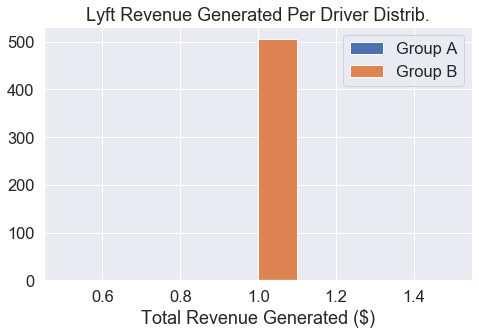

In [337]:
dlv_rev = pop1_df.groupby(['driver_id'])['ride_id'].unique().value_counts()
# print(dlv_rev.shape)
# print(dlv_rev.mean() , " +/- ", dlv_rev.sem())
nbins = 10

fig, ax = plt.subplots(1,1, figsize=(7,5))
hist = dlv_rev.hist(ax=ax, bins=nbins, label="Group A")

dlv_rev = pop2_df.groupby(['driver_id'])['ride_id'].unique().value_counts()
# print(dlv_rev.shape)
# print(dlv_rev.mean() , " +/- ", dlv_rev.sem())
hist = dlv_rev.hist(ax=ax, bins=nbins, label="Group B")
# ax.set_title("Lyft Revenue Generated Per Driver Distrib. (Pop2)")
# ax.set_xlabel("Total Revenue Generated ($)")

ax.set_title("Lyft Revenue Generated Per Driver Distrib.")
ax.set_xlabel("Total Revenue Generated ($)")
ax.legend()
fig.tight_layout()
# plt.savefig("../reports/figures/total_revenue_generated_perdriver_bimodal.pdf")

(340,)
74.1609288235294  +/-  1.8472910390240982
(504,)
547.5048859126983  +/-  10.04415078130178


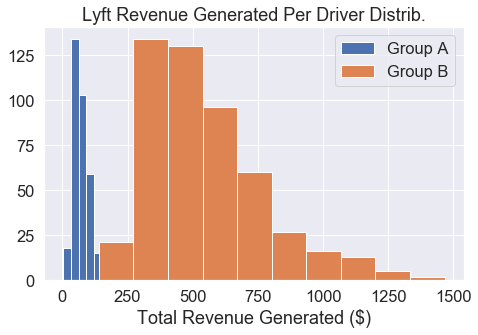

In [344]:
dlv_rev = pop1_df.groupby(['driver_id'])['lyft_rev'].sum()
print(dlv_rev.shape)
print(dlv_rev.mean() , " +/- ", dlv_rev.sem())
nbins = 10

fig, ax = plt.subplots(1,1, figsize=(7,5))
hist = dlv_rev.hist(ax=ax, bins=nbins, label="Group A")

dlv_rev = pop2_df.groupby(['driver_id'])['lyft_rev'].sum()
print(dlv_rev.shape)
print(dlv_rev.mean() , " +/- ", dlv_rev.sem())
hist = dlv_rev.hist(ax=ax, bins=nbins, label="Group B")
# ax.set_title("Lyft Revenue Generated Per Driver Distrib. (Pop2)")
# ax.set_xlabel("Total Revenue Generated ($)")

ax.set_title("Lyft Revenue Generated Per Driver Distrib.")
ax.set_xlabel("Total Revenue Generated ($)")
ax.legend()
fig.tight_layout()
plt.savefig("../reports/figures/total_revenue_generated_perdriver_bimodal.pdf")

(338,)
72.87536656804734  +/-  1.6562618996647893
(506,)
546.4926964426878  +/-  10.027177473588903


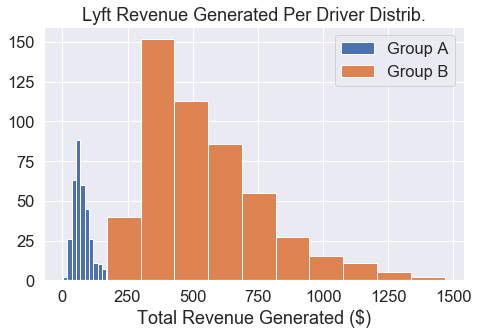

In [199]:
dlv_rev = pop1_df.groupby(['driver_id'])['lyft_rev_y'].sum()
print(dlv_rev.shape)
print(dlv_rev.mean() , " +/- ", dlv_rev.sem())
nbins = 10

fig, ax = plt.subplots(1,1, figsize=(7,5))
hist = dlv_rev.hist(ax=ax, bins=nbins, label="Group A")

dlv_rev = pop2_df.groupby(['driver_id'])['lyft_rev_y'].sum()
print(dlv_rev.shape)
print(dlv_rev.mean() , " +/- ", dlv_rev.sem())
hist = dlv_rev.hist(ax=ax, bins=nbins, label="Group B")
# ax.set_title("Lyft Revenue Generated Per Driver Distrib. (Pop2)")
# ax.set_xlabel("Total Revenue Generated ($)")

ax.set_title("Lyft Revenue Generated Per Driver Distrib.")
ax.set_xlabel("Total Revenue Generated ($)")
ax.legend()
fig.tight_layout()
plt.savefig("../reports/figures/total_revenue_generated_perdriver_bimodal.pdf")

356.82130130331745  +/-  10.021773384956692
(844,)


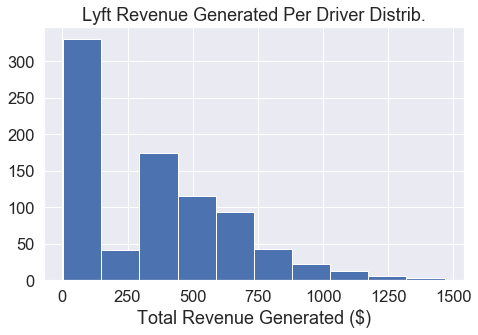

In [200]:
dlv_rev = nride_df.groupby(['driver_id'])['lyft_rev'].sum()
print(dlv_rev.mean() , " +/- ", dlv_rev.sem())
print(dlv_rev.shape)
nbins = 10

fig, ax = plt.subplots(1,1,figsize=(7,5))
hist = dlv_rev.hist(ax=ax, bins=nbins)
ax.set_title("Lyft Revenue Generated Per Driver Distrib.")
ax.set_xlabel("Total Revenue Generated ($)")
fig.tight_layout()
plt.savefig("../reports/figures/total_revenue_generated_perdriver.pdf")

In [285]:
print(nride_df["fare_total"].mean())

,driver_id,ride_id,ride_distance,ride_duration,ride_prime_time,is_prime_time,event,timestamp,time_of_day,weekday,month,day_of_week,driver_onboard_date,time_since_onboard,time_until_last_event
0,002be0ffdc997bd5c50703158b7c2491,006d61cf7446e682f7bc50b0f8a5bea5,1811,327,50,True,requested_at,2016-04-23 02:13:50,1,1.0,4,Saturday,2016-03-29,25 days 02:13:50,0.721185
1,002be0ffdc997bd5c50703158b7c2491,01b522c5c3a756fbdb12e95e87507eda,3362,809,0,False,requested_at,2016-03-29 19:00:49,4,0.0,3,Tuesday,2016-03-29,0 days 19:00:49,0.991197


KeyError: 'fare_total'

# Determine APL for one and then all drivers

- compute time until last datapoint (all drivers)
- compute time since onboard (per driver)

In [252]:
display(drive_df.head())

nride_df = nride_df.merge(drive_df, how="left", on="driver_id")
display(nride_df.head())

,driver_id,driver_onboard_date
0,002be0ffdc997bd5c50703158b7c2491,2016-03-29 00:00:00
1,007f0389f9c7b03ef97098422f902e62,2016-03-29 00:00:00
2,011e5c5dfc5c2c92501b8b24d47509bc,2016-04-05 00:00:00
3,0152a2f305e71d26cc964f8d4411add9,2016-04-23 00:00:00
4,01674381af7edd264113d4e6ed55ecda,2016-04-29 00:00:00


,driver_id,ride_id,ride_distance,ride_duration,ride_prime_time,is_prime_time,event,timestamp,time_of_day,weekday,month,day_of_week,driver_onboard_date
0,002be0ffdc997bd5c50703158b7c2491,006d61cf7446e682f7bc50b0f8a5bea5,1811,327,50,True,requested_at,2016-04-23 02:13:50,1,1.0,4,Saturday,2016-03-29 00:00:00
1,002be0ffdc997bd5c50703158b7c2491,01b522c5c3a756fbdb12e95e87507eda,3362,809,0,False,requested_at,2016-03-29 19:00:49,4,0.0,3,Tuesday,2016-03-29 00:00:00
2,002be0ffdc997bd5c50703158b7c2491,029227c4c2971ce69ff2274dc798ef43,3282,572,0,False,requested_at,2016-06-21 11:56:31,2,0.0,6,Tuesday,2016-03-29 00:00:00
3,002be0ffdc997bd5c50703158b7c2491,034e861343a63ac3c18a9ceb1ce0ac69,65283,3338,25,True,requested_at,2016-05-19 09:15:29,2,0.0,5,Thursday,2016-03-29 00:00:00
4,002be0ffdc997bd5c50703158b7c2491,034f2e614a2f9fc7f1c2f77647d1b981,4115,823,100,True,requested_at,2016-04-20 22:05:30,4,0.0,4,Wednesday,2016-03-29 00:00:00


In [283]:
print(nride_df["driver_onboard_date"].min(), nride_df["driver_onboard_date"].max())

2016-03-28 00:00:00 2016-05-15 00:00:00


In [253]:
nride_df["timestamp"] = pd.to_datetime(nride_df["timestamp"])
nride_df["driver_onboard_date"] = pd.to_datetime(nride_df["driver_onboard_date"])

display(nride_df.head(2))

,driver_id,ride_id,ride_distance,ride_duration,ride_prime_time,is_prime_time,event,timestamp,time_of_day,weekday,month,day_of_week,driver_onboard_date
0,002be0ffdc997bd5c50703158b7c2491,006d61cf7446e682f7bc50b0f8a5bea5,1811,327,50,True,requested_at,2016-04-23 02:13:50,1,1.0,4,Saturday,2016-03-29
1,002be0ffdc997bd5c50703158b7c2491,01b522c5c3a756fbdb12e95e87507eda,3362,809,0,False,requested_at,2016-03-29 19:00:49,4,0.0,3,Tuesday,2016-03-29


In [256]:
# compute time since onboard
nride_df["time_since_onboard"] = nride_df["timestamp"] - nride_df["driver_onboard_date"]
print(nride_df["time_since_onboard"].dtype)
display(nride_df.head())

timedelta64[ns]


,driver_id,ride_id,ride_distance,ride_duration,ride_prime_time,is_prime_time,event,timestamp,time_of_day,weekday,month,day_of_week,driver_onboard_date,time_since_onboard
0,002be0ffdc997bd5c50703158b7c2491,006d61cf7446e682f7bc50b0f8a5bea5,1811,327,50,True,requested_at,2016-04-23 02:13:50,1,1.0,4,Saturday,2016-03-29,25 days 02:13:50
1,002be0ffdc997bd5c50703158b7c2491,01b522c5c3a756fbdb12e95e87507eda,3362,809,0,False,requested_at,2016-03-29 19:00:49,4,0.0,3,Tuesday,2016-03-29,0 days 19:00:49
2,002be0ffdc997bd5c50703158b7c2491,029227c4c2971ce69ff2274dc798ef43,3282,572,0,False,requested_at,2016-06-21 11:56:31,2,0.0,6,Tuesday,2016-03-29,84 days 11:56:31
3,002be0ffdc997bd5c50703158b7c2491,034e861343a63ac3c18a9ceb1ce0ac69,65283,3338,25,True,requested_at,2016-05-19 09:15:29,2,0.0,5,Thursday,2016-03-29,51 days 09:15:29
4,002be0ffdc997bd5c50703158b7c2491,034f2e614a2f9fc7f1c2f77647d1b981,4115,823,100,True,requested_at,2016-04-20 22:05:30,4,0.0,4,Wednesday,2016-03-29,22 days 22:05:30


In [280]:
# compute time since onboard
nride_df["time_until_last_event"] = (nride_df["timestamp"].max() - nride_df["timestamp"])/ \
                                    (nride_df["timestamp"].max() - nride_df["driver_onboard_date"])
print(nride_df["timestamp"].max())
print(nride_df["time_until_last_event"].dtype)
display(nride_df.head())

2016-06-26 23:57:45
float64


,driver_id,ride_id,ride_distance,ride_duration,ride_prime_time,is_prime_time,event,timestamp,time_of_day,weekday,month,day_of_week,driver_onboard_date,time_since_onboard,time_until_last_event
0,002be0ffdc997bd5c50703158b7c2491,006d61cf7446e682f7bc50b0f8a5bea5,1811,327,50,True,requested_at,2016-04-23 02:13:50,1,1.0,4,Saturday,2016-03-29,25 days 02:13:50,0.721185
1,002be0ffdc997bd5c50703158b7c2491,01b522c5c3a756fbdb12e95e87507eda,3362,809,0,False,requested_at,2016-03-29 19:00:49,4,0.0,3,Tuesday,2016-03-29,0 days 19:00:49,0.991197
2,002be0ffdc997bd5c50703158b7c2491,029227c4c2971ce69ff2274dc798ef43,3282,572,0,False,requested_at,2016-06-21 11:56:31,2,0.0,6,Tuesday,2016-03-29,84 days 11:56:31,0.061122
3,002be0ffdc997bd5c50703158b7c2491,034e861343a63ac3c18a9ceb1ce0ac69,65283,3338,25,True,requested_at,2016-05-19 09:15:29,2,0.0,5,Thursday,2016-03-29,51 days 09:15:29,0.429037
4,002be0ffdc997bd5c50703158b7c2491,034f2e614a2f9fc7f1c2f77647d1b981,4115,823,100,True,requested_at,2016-04-20 22:05:30,4,0.0,4,Wednesday,2016-03-29,22 days 22:05:30,0.745324


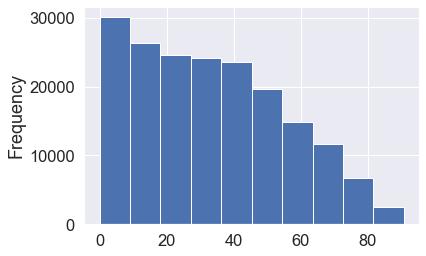

In [258]:
(nride_df['time_since_onboard'].astype('timedelta64[h]')/24).plot.hist()

,driver_id,ride_id,ride_distance,ride_duration,ride_prime_time,is_prime_time,event,timestamp,time_of_day,weekday,month,day_of_week,driver_onboard_date,time_since_onboard,time_until_last_event
247,002be0ffdc997bd5c50703158b7c2491,e228d93dc13a2a9d83661321992cd48e,2480,346,0,False,requested_at,2016-03-29 18:46:50,4,0.0,3,Tuesday,2016-03-29,18:46:50,89 days 05:10:55
1,002be0ffdc997bd5c50703158b7c2491,01b522c5c3a756fbdb12e95e87507eda,3362,809,0,False,requested_at,2016-03-29 19:00:49,4,0.0,3,Tuesday,2016-03-29,19:00:49,89 days 04:56:56
205,002be0ffdc997bd5c50703158b7c2491,b67eaf39b42e3c3320cc40c08b8d3ec1,4165,836,0,False,requested_at,2016-03-29 19:43:55,4,0.0,3,Tuesday,2016-03-29,19:43:55,89 days 04:13:50
108,002be0ffdc997bd5c50703158b7c2491,5f5aa96468d1df5c21e17dd696f4f9c6,1393,255,0,False,requested_at,2016-03-29 21:45:41,4,0.0,3,Tuesday,2016-03-29,21:45:41,89 days 02:12:04
262,002be0ffdc997bd5c50703158b7c2491,f5ce5206cbe22905137b6568ba8786b0,2129,373,25,True,requested_at,2016-03-29 22:17:28,4,0.0,3,Tuesday,2016-03-29,22:17:28,89 days 01:40:17


(277, 15)


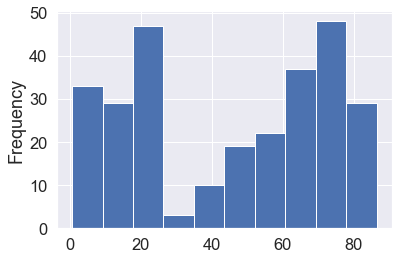

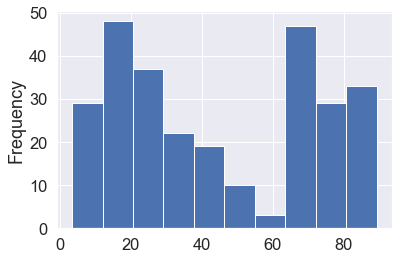

In [264]:
# display(nride_df.head())
this_driver = nride_df[nride_df["driver_id"] == "002be0ffdc997bd5c50703158b7c2491"].copy()

# sort by timestamp
this_driver.sort_values(by="timestamp", inplace=True)

# compute the time sequence of rides
fig, ax= plt.subplots(1,1)
(this_driver['time_since_onboard'].astype('timedelta64[h]')/24).plot.hist()

fig, ax= plt.subplots(1,1)
(this_driver['time_until_last_event'].astype('timedelta64[h]')/24).plot.hist()

display(this_driver.head())
print(this_driver.shape)

,driver_id,ride_id,ride_distance,ride_duration,ride_prime_time,is_prime_time,event,timestamp,time_of_day,weekday,month,day_of_week,driver_onboard_date,time_since_onboard,time_until_last_event
0,002be0ffdc997bd5c50703158b7c2491,006d61cf7446e682f7bc50b0f8a5bea5,1811,327,50,True,requested_at,2016-04-23 02:13:50,1,1.0,4,Saturday,2016-03-29,25 days 02:13:50,0.721185
1,002be0ffdc997bd5c50703158b7c2491,01b522c5c3a756fbdb12e95e87507eda,3362,809,0,False,requested_at,2016-03-29 19:00:49,4,0.0,3,Tuesday,2016-03-29,0 days 19:00:49,0.991197
2,002be0ffdc997bd5c50703158b7c2491,029227c4c2971ce69ff2274dc798ef43,3282,572,0,False,requested_at,2016-06-21 11:56:31,2,0.0,6,Tuesday,2016-03-29,84 days 11:56:31,0.061122
3,002be0ffdc997bd5c50703158b7c2491,034e861343a63ac3c18a9ceb1ce0ac69,65283,3338,25,True,requested_at,2016-05-19 09:15:29,2,0.0,5,Thursday,2016-03-29,51 days 09:15:29,0.429037
4,002be0ffdc997bd5c50703158b7c2491,034f2e614a2f9fc7f1c2f77647d1b981,4115,823,100,True,requested_at,2016-04-20 22:05:30,4,0.0,4,Wednesday,2016-03-29,22 days 22:05:30,0.745324


(184819, 15)


,sum,mean,std
driver_id,,,
002be0ffdc997bd5c50703158b7c2491,137.155783,0.495147,0.306424
007f0389f9c7b03ef97098422f902e62,15.239594,0.491600,0.244020
011e5c5dfc5c2c92501b8b24d47509bc,20.153538,0.592751,0.274749
0152a2f305e71d26cc964f8d4411add9,78.822905,0.412685,0.303401
01674381af7edd264113d4e6ed55ecda,183.918575,0.490450,0.287488


(844, 3)
0.594429163209655  +/-  0.0057556446954597435


Text(0.5, 1.0, 'Average time until end of dataset per driver')

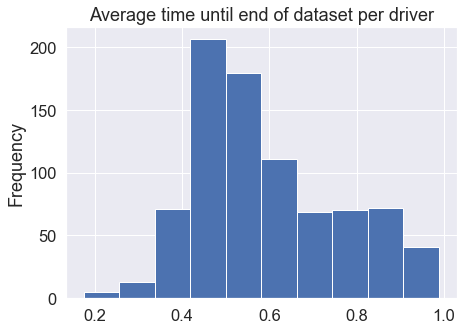

In [282]:
df = nride_df.copy()
display(df.head())
print(df.shape)
test = df.groupby("driver_id")["time_until_last_event"].agg(["sum", "mean", "std"])#.value_counts().unstack().stack(dropna=False).reset_index(name="Count")
display(test.head())
print(test.shape)
std = test["std"]

print(test["mean"].mean() , " +/- ", test["mean"].sem())

fig, ax = plt.subplots(1,1, figsize=(7,5))
test["mean"].plot(kind="hist", ax=ax, 
#                   yerr=std
                 )
ax.set_title("Average time until end of dataset per driver")
# plt.savefig("../reports/figures/avg_number_rides_per_monthdriver.pdf")

,driver_id,ride_id,ride_distance,ride_duration,ride_prime_time,is_prime_time,event,timestamp,time_of_day,weekday,month,day_of_week,driver_onboard_date,time_since_onboard,time_until_last_event
0,002be0ffdc997bd5c50703158b7c2491,006d61cf7446e682f7bc50b0f8a5bea5,1811,327,50,True,requested_at,2016-04-23 02:13:50,1,1.0,4,Saturday,2016-03-29,25 days 02:13:50,64 days 21:43:55
1,002be0ffdc997bd5c50703158b7c2491,01b522c5c3a756fbdb12e95e87507eda,3362,809,0,False,requested_at,2016-03-29 19:00:49,4,0.0,3,Tuesday,2016-03-29,0 days 19:00:49,89 days 04:56:56
2,002be0ffdc997bd5c50703158b7c2491,029227c4c2971ce69ff2274dc798ef43,3282,572,0,False,requested_at,2016-06-21 11:56:31,2,0.0,6,Tuesday,2016-03-29,84 days 11:56:31,5 days 12:01:14
3,002be0ffdc997bd5c50703158b7c2491,034e861343a63ac3c18a9ceb1ce0ac69,65283,3338,25,True,requested_at,2016-05-19 09:15:29,2,0.0,5,Thursday,2016-03-29,51 days 09:15:29,38 days 14:42:16
4,002be0ffdc997bd5c50703158b7c2491,034f2e614a2f9fc7f1c2f77647d1b981,4115,823,100,True,requested_at,2016-04-20 22:05:30,4,0.0,4,Wednesday,2016-03-29,22 days 22:05:30,67 days 01:52:15


(184819, 15)


,sum,mean,std
driver_id,,,
002be0ffdc997bd5c50703158b7c2491,12337.958333,44.541366,27.577694
007f0389f9c7b03ef97098422f902e62,1370.958333,44.224462,21.962151
011e5c5dfc5c2c92501b8b24d47509bc,1672.041667,49.177696,22.806887
0152a2f305e71d26cc964f8d4411add9,5119.250000,26.802356,19.719855
01674381af7edd264113d4e6ed55ecda,10843.250000,28.915333,16.961707


(844, 3)


Text(0.5, 1.0, 'Average time until end of dataset per driver')

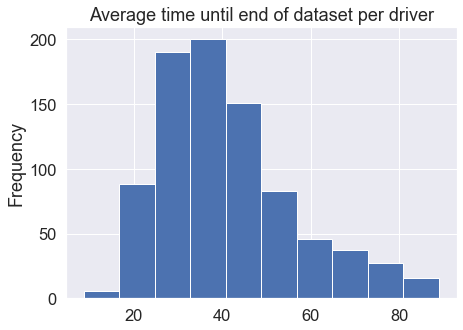

In [277]:
df = nride_df.copy()
display(df.head())
print(df.shape)
df["time_until_last_event"] = df["time_until_last_event"].astype('timedelta64[h]')/24
test = df.groupby("driver_id")["time_until_last_event"].agg(["sum", "mean", "std"])#.value_counts().unstack().stack(dropna=False).reset_index(name="Count")
display(test.head())
print(test.shape)
std = test["std"]

fig, ax = plt.subplots(1,1, figsize=(7,5))
test["mean"].plot(kind="hist", ax=ax, 
#                   yerr=std
                 )
ax.set_title("Average time until end of dataset per driver")
# plt.savefig("../reports/figures/avg_number_rides_per_monthdriver.pdf")

,driver_id,ride_id,ride_distance,ride_duration,ride_prime_time,is_prime_time,event,timestamp,time_of_day,weekday,month,day_of_week,driver_onboard_date,time_since_onboard,time_until_last_event
0,002be0ffdc997bd5c50703158b7c2491,006d61cf7446e682f7bc50b0f8a5bea5,1811,327,50,True,requested_at,2016-04-23 02:13:50,1,1.0,4,Saturday,2016-03-29,25 days 02:13:50,64 days 21:43:55
1,002be0ffdc997bd5c50703158b7c2491,01b522c5c3a756fbdb12e95e87507eda,3362,809,0,False,requested_at,2016-03-29 19:00:49,4,0.0,3,Tuesday,2016-03-29,0 days 19:00:49,89 days 04:56:56
2,002be0ffdc997bd5c50703158b7c2491,029227c4c2971ce69ff2274dc798ef43,3282,572,0,False,requested_at,2016-06-21 11:56:31,2,0.0,6,Tuesday,2016-03-29,84 days 11:56:31,5 days 12:01:14
3,002be0ffdc997bd5c50703158b7c2491,034e861343a63ac3c18a9ceb1ce0ac69,65283,3338,25,True,requested_at,2016-05-19 09:15:29,2,0.0,5,Thursday,2016-03-29,51 days 09:15:29,38 days 14:42:16
4,002be0ffdc997bd5c50703158b7c2491,034f2e614a2f9fc7f1c2f77647d1b981,4115,823,100,True,requested_at,2016-04-20 22:05:30,4,0.0,4,Wednesday,2016-03-29,22 days 22:05:30,67 days 01:52:15


(184819, 15)


,sum,mean,std
driver_id,,,
002be0ffdc997bd5c50703158b7c2491,12580.333333,45.416366,27.577453
007f0389f9c7b03ef97098422f902e62,1417.708333,45.732527,21.963353
011e5c5dfc5c2c92501b8b24d47509bc,1148.541667,33.780637,22.806887
0152a2f305e71d26cc964f8d4411add9,7287.416667,38.154014,19.719375
01674381af7edd264113d4e6ed55ecda,11265.625000,30.041667,16.962091


(844, 3)


Text(0.5, 1.0, 'Average time since onboard per driver')

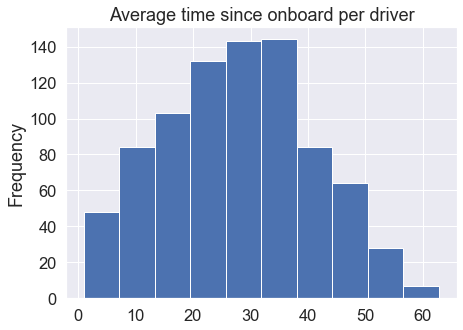

In [275]:
df = nride_df.copy()
display(df.head())
print(df.shape)
df["time_since_onboard"] = df["time_since_onboard"].astype('timedelta64[h]')/24
test = df.groupby("driver_id")['time_since_onboard'].agg(["sum", "mean", "std"])#.value_counts().unstack().stack(dropna=False).reset_index(name="Count")
display(test.head())
print(test.shape)
std = test["std"]

fig, ax = plt.subplots(1,1, figsize=(7,5))
test["mean"].plot(kind="hist", ax=ax, 
#                   yerr=std
                 )
ax.set_title("Average time since onboard per driver")
# plt.savefig("../reports/figures/avg_number_rides_per_monthdriver.pdf")

In [276]:
print("done")

done


# Save Pop1 and Pop2 and Analyze

In [204]:
fpath = "../data/interim/pop1.csv"
pop1_df.to_csv(fpath, index=False)

In [203]:
fpath = "../data/interim/pop2.csv"
pop2_df.to_csv(fpath, index=False)